In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle as pkl
import glob

In [69]:
# compute the average accuracy per batch of data
df = pd.read_csv("Exp_502_602_combined.csv") # the combined data file
table = np.zeros((5, 3))

# list through all the experiments (both trajectories)
for k, m in enumerate(['LSN', 'ANN', 'SVM', 'RF', 'LR']):
    stats = {'OK': [0, 0], 'New': [0, 0], 'Add': [0, 0]}
    
    for filename in glob.glob('results/Exp_Mar18_grid_search/{}*78_GridSearch_perf_df.pkl'.format(m)):
        with open(filename, 'rb') as f:
            data = pkl.load(f)

        for i in range(10):
            if 'subject_id' in data[i].keys():
                subject_id = data[i]['subject_id']
                label = data[i]['label'] # true trajectory
                pred_prob = np.array(data[i]['pred_prob']) # predicted trajectory

                for j in range(subject_id.shape[0]):
                    # status = 'OK', 'New', or 'Add'
                    # OK: Nikhil original data
                    # New: data obtained after first CIVET batch (missing data)
                    # Add: data obtained after second CIVET batch (missing 12 months time point)
                    status = df[df['PTID'] == subject_id[j]]['STATUS'].values[0]

                    y_pred = np.argmax(pred_prob[j])
                    stats[status][1] += 1 # count total number of predictions
                    if label[j] == y_pred: 
                        stats[status][0] += 1 # count correct predictions

    print("Original data accuracy with {} method: {:.4f}".format(m, stats['OK'][0] / stats['OK'][1]))
    print("Missing data accuracy with {} method: {:.4f}".format(m, stats['New'][0] / stats['New'][1]))
    print("New 12 months data accuracy with {} method: {:.4f}".format(m, stats['Add'][0] / stats['Add'][1]))
    
    table[k][0] = stats['OK'][0] / stats['OK'][1]
    table[k][1] = stats['New'][0] / stats['New'][1]
    table[k][2] = stats['Add'][0] / stats['Add'][1]
print(table)

Original data accuracy with LSN method: 0.8229
Missing data accuracy with LSN method: 0.8079
New 12 months data accuracy with LSN method: 0.8286
Original data accuracy with ANN method: 0.8542
Missing data accuracy with ANN method: 0.8770
New 12 months data accuracy with ANN method: 0.8707
Original data accuracy with SVM method: 0.8816
Missing data accuracy with SVM method: 0.8906
New 12 months data accuracy with SVM method: 0.8771
Original data accuracy with RF method: 0.8566
Missing data accuracy with RF method: 0.8600
New 12 months data accuracy with RF method: 0.8599
Original data accuracy with LR method: 0.8764
Missing data accuracy with LR method: 0.8821
New 12 months data accuracy with LR method: 0.8643
[[0.82288557 0.80794702 0.82857143]
 [0.85415282 0.87702128 0.87070064]
 [0.88156146 0.8906383  0.87707006]
 [0.85664452 0.86       0.85987261]
 [0.87641196 0.88212766 0.86433121]]


In [50]:
# investigate differences between batches of data

nikhil_ok = df[df["STATUS"] == "OK"] # original Nikhil data
stats = {'BE': [0, 0], 'FE': [0, 0], 'CC': [0, 0]}
for index, row in nikhil_ok.iterrows():
    stats[row['MMSE_gr']][row['MMSE_2c_traj']] += 1
sample_size = nikhil_ok.values.shape[0]
for key in stats.keys():
    stats[key][0] /= float(sample_size)
    stats[key][1] /= float(sample_size)
print("Statistics of original data: {}".format(stats))

charles_new = df[df["STATUS"] == "New"] # Charles collected missing data
stats = {'BE': [0, 0], 'FE': [0, 0], 'CC': [0, 0]}
for index, row in charles_new.iterrows():
    stats[row['MMSE_gr']][row['MMSE_2c_traj']] += 1
sample_size = charles_new.values.shape[0]
for key in stats.keys():
    stats[key][0] /= float(sample_size)
    stats[key][1] /= float(sample_size)
print("Statistics of missing data: {}".format(stats))

charles_add = df[df["STATUS"] == "Add"] # Charles 12 months new data
stats = {'BE': [0, 0], 'FE': [0, 0], 'CC': [0, 0]}
for index, row in charles_add.iterrows():
    stats[row['MMSE_gr']][row['MMSE_2c_traj']] += 1
sample_size = charles_add.values.shape[0]
for key in stats.keys():
    stats[key][0] /= float(sample_size)
    stats[key][1] /= float(sample_size)
print("Statistics of new 12 months data: {}".format(stats))

Statistics of original data: {'BE': [0.3637873754152824, 0.19435215946843853], 'FE': [0.09302325581395349, 0.14451827242524917], 'CC': [0.07807308970099668, 0.12624584717607973]}
Statistics of missing data: {'BE': [0.4723404255319149, 0.12340425531914893], 'FE': [0.08936170212765958, 0.10212765957446808], 'CC': [0.1148936170212766, 0.09787234042553192]}
Statistics of new 12 months data: {'BE': [0.4968152866242038, 0.17197452229299362], 'FE': [0.14012738853503184, 0.025477707006369428], 'CC': [0.11464968152866242, 0.050955414012738856]}


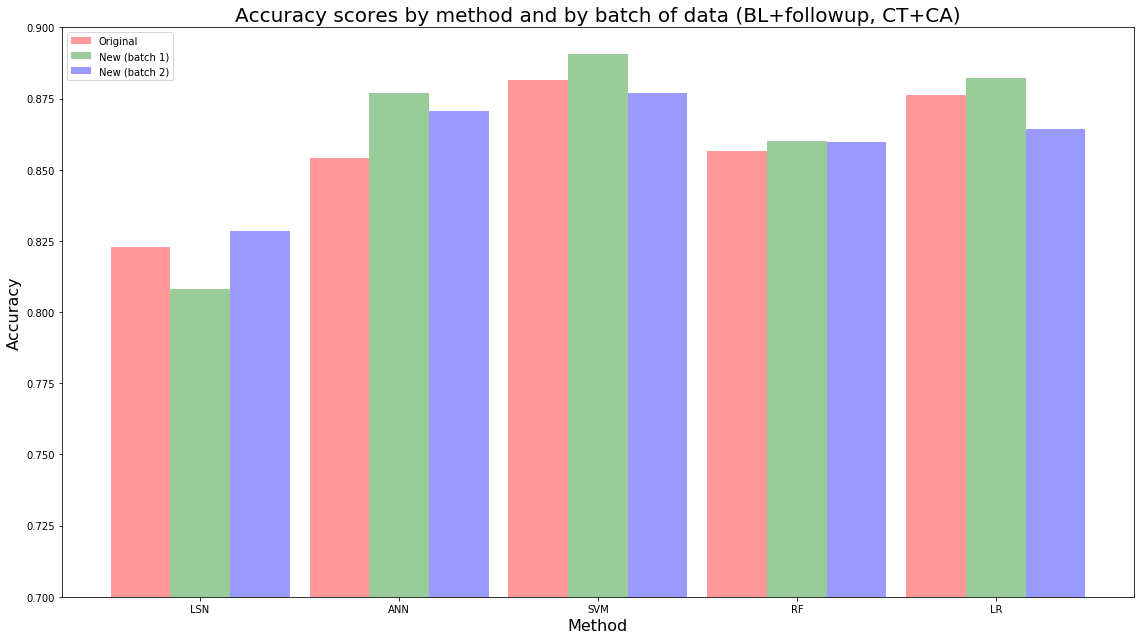

In [86]:
# plot a summary of the model performances

fig, ax = plt.subplots(figsize=(16,9))

bar_width = 0.30
opacity = 0.4

rects1 = ax.bar(np.arange(5), table[:,0], bar_width, alpha=opacity, color='r', label='Original')
rects2 = ax.bar(np.arange(5) + bar_width, table[:,1], bar_width, alpha=opacity, color='g', label='New (batch 1)')
rects3 = ax.bar(np.arange(5) + 2*bar_width, table[:,2], bar_width, alpha=opacity, color='b', label='New (batch 2)')

ax.set_xlabel('Method', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_title('Accuracy scores by method and by batch of data (BL+followup, CT+CA)', fontsize=20)
ax.set_xticks(np.arange(5) + bar_width)
ax.set_xticklabels(('LSN', 'ANN', 'SVM', 'RF', 'LR'))
ax.set_ylim(0.7, 0.9)

ax.legend()

fig.tight_layout()
plt.savefig("verify_performance.png")
plt.show()

In [ ]:
# verify if some other variables lead to a change in perfo